# Revision

There are a few issues with our current approach:
- While the coefficients of a linear model reflect the contributing factor of a variable, 
  they depend on the scale of the respective variable and are therefore only comparable
  among variables of the same scale.
- Previous plots indicate a non-linear relationship between e.g. TV and sales.
- It seems plausible that variables contribute jointly to the sales, as larger marketing 
  campaigns often target several platforms at once.


Let's see if we can improve our model to remedy these deficiencies.

**Prepare our coding setup**

In [1]:
# code starts here
# some of the tools we use
from itertools import product

from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# These imports may not work out of the box when you run the code in Google Colab
# from util import XNAMES, YNAME, COLORS
# from util import plot_coefficients, generate_valid_budget_allocations, create_model_explorer, generate_budget_plans, predict_sales_and_compare_plans

# Therefore I include the code literally here.
# util.py
"""
Utilities to simplify live coding.
"""
from itertools import product

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


COLORS = {
    'TV': '#1b9e77',
    'radio': '#d95f02',
    'newspaper': '#7570b3',
}
XNAMES = ['TV', 'radio', 'newspaper']
YNAME = 'sales'


def plot_coefficients(coef, names):
    importance = pd.Series(coef, index=names, name='coef')
    fig, ax = plt.subplots()
    importance.plot.bar(ax=ax)
    ax.set_title('Coefficients')
    return fig


def create_model_explorer(df, model):

    def explore_budget_plan(tv_budget=140, radio_budget=20, newspaper_budget=30):
        planned_budget = pd.DataFrame([[tv_budget, radio_budget, newspaper_budget]], columns=XNAMES)
        
        sales_pred = model.predict(planned_budget)

        fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)
        for xname, ax in zip(XNAMES, axs):
            df.plot.scatter(ax=ax, x=xname, y=YNAME, color=COLORS[xname])

        for xname, ax in zip(XNAMES, axs):
            ax.scatter(planned_budget[xname][0], sales_pred, color='k', s=800, marker='+')
            # TODO add vlines and hlines
        return fig
        
    return explore_budget_plan  
 

def generate_valid_budget_allocations(total_budget):
    
    budget_options = range(0, total_budget + 1, 2)
    
    budget_allocations = []
    for budget_allocation in product(budget_options, budget_options, budget_options):
        if sum(budget_allocation) != total_budget:
            continue
        budget_allocations.append(budget_allocation)
    return pd.DataFrame(budget_allocations, columns=XNAMES)


def generate_budget_plans(reference, extra):
    budget_plans = reference[XNAMES].values + extra
    return budget_plans


def predict_sales_and_compare_plans(model, reference, budget_plans):
    sales_pred = model.predict(budget_plans)

    plan = budget_plans.copy()
    plan['predicted_sales'] = sales_pred
    
    absolute_difference = (plan - reference.values).sort_values('predicted_sales', ascending=False)

    relative_difference = ((plan - reference.values)/reference.values).sort_values('predicted_sales', ascending=False)

    return absolute_difference, relative_difference


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('https://www.statlearning.com/s/Advertising.csv', index_col=0)
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


## Update Model

Questions:
* How can we adjust our model, in order to address above concerns?

In [3]:
from sklearn.model_selection import train_test_split

X = df[XNAMES]
y = df[YNAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
from sklearn.linear_model import LinearRegression  # our second machine learning model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

model = Pipeline([('scale', StandardScaler()), 
                  ('feature', PolynomialFeatures(degree=3)),
                  ('model', LinearRegression(fit_intercept=False))])
model

Pipeline(steps=[('scale', StandardScaler()),
                ('feature', PolynomialFeatures(degree=3)),
                ('model', LinearRegression(fit_intercept=False))])

In [5]:
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('feature', PolynomialFeatures(degree=3)),
                ('model', LinearRegression(fit_intercept=False))])

In [6]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred[:3]

array([17.10516312, 22.22856773, 21.49375471])

### Evaluate & Compare (REVISED!)

#### Score

In [7]:
from sklearn.metrics import r2_score
# https://en.wikipedia.org/wiki/Coefficient_of_determination
# the closer to 1 the better

r2_score(y_test, y_test_pred)

0.9909156208541124

In [8]:
# or even easier
model.score(X_test, y_test), model.score(X_train, y_train)

(0.9909156208541124, 0.9915825241576748)

#### Visualize (Actual vs Prediction)

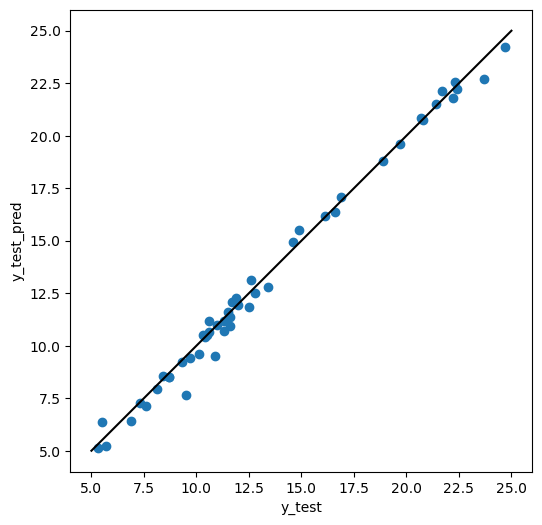

In [9]:
# or plot actual vs. prediction
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, y_test_pred)
ax.plot([5, 25], [5, 25], color='black')
ax.axis('square')
ax.set_xlabel('y_test')
ax.set_ylabel('y_test_pred')
fig

**Visualize (Residuals = Actual - Pred)**

In [10]:
df_test = X_test.assign(sales=y_test, sales_pred=y_test_pred)
df_test['actual-pred'] = df_test['sales'] - df_test['sales_pred']

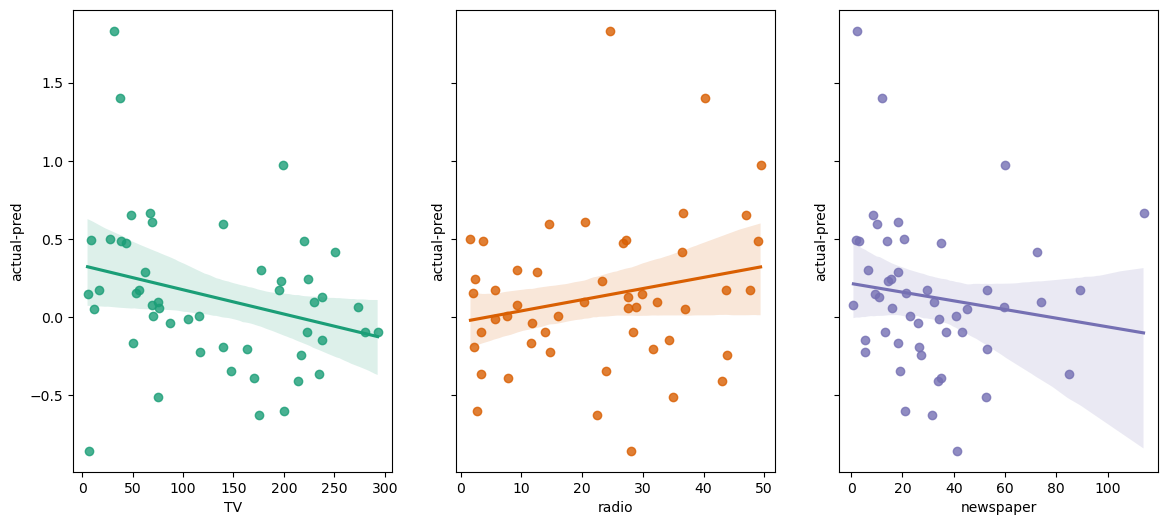

In [11]:
fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)

for xname, ax in zip(XNAMES, axs):
    sns.regplot(data=df_test, x=xname, y='actual-pred' , color=COLORS[xname], ax=ax)

fig

## Fine-tune your models and combine them into a great solution.

Let's take it step by step and see how our model from above can contribute to a solution.

Questions:
* What are we going to do now?

### Q&A: Investment in which channel is most valuable? (REVISED!)

We can take a look at the model coefficients. The larger the absolute value of the coefficient, the more important the contributing factor.

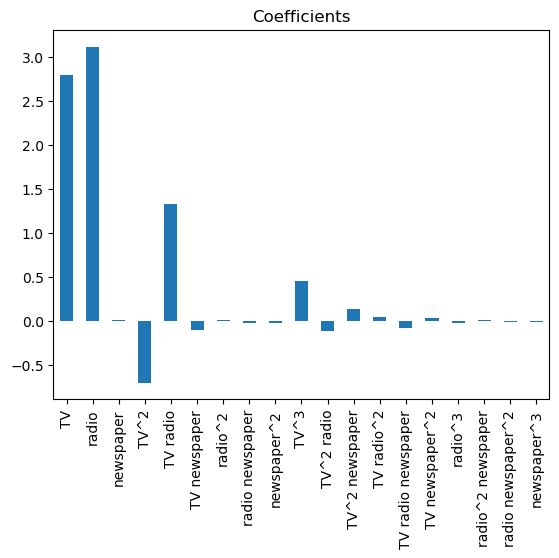

In [12]:
coef = model.steps[2][1].coef_
feature_names = model.steps[1][1].get_feature_names_out(XNAMES)

plot_coefficients(coef[1:], feature_names[1:])

In [13]:
explorer = interact(create_model_explorer(df_test, model), 
                    tv_budget=(0, 300), 
                    radio_budget=(0, 50),
                    newspaper_budget=(0, 100))
explorer

interactive(children=(IntSlider(value=140, description='tv_budget', max=300), IntSlider(value=20, description=…

<function __main__.create_model_explorer.<locals>.explore_budget_plan(tv_budget=140, radio_budget=20, newspaper_budget=30)>

### Q&A: How to optimally distribute additional resources? (REVISED!)

Procedure:
1. Compute a range of different budget plans.
1. Make a prediction of each budget plan.
1. Assess the result.
1. Pick the plan with the largest increase in sales.

In [14]:
total_extra_budget = 20
extra_budget_allocations = generate_valid_budget_allocations(total_extra_budget)
extra_budget_allocations.sample(n=5)

,TV,radio,newspaper
16,2,10,8
28,4,14,2
42,8,8,4
14,2,6,12
31,6,2,12


**Scenario**

In [15]:
average_spending = df.mean(axis=0).to_frame().T
average_spending

,TV,radio,newspaper,sales
0,147.0425,23.264,30.554,14.0225


In [16]:
status_quo = df.iloc[[1], :]
status_quo

,TV,radio,newspaper,sales
2,44.5,39.3,45.1,10.4


**Possible Budget Plans**

In [17]:
possible_budget_plans = generate_budget_plans(status_quo, extra_budget_allocations)
possible_budget_plans

,TV,radio,newspaper
0,44.5,39.3,65.1
1,44.5,41.3,63.1
2,44.5,43.3,61.1
3,44.5,45.3,59.1
4,44.5,47.3,57.1
...,...,...,...
61,60.5,41.3,47.1
62,60.5,43.3,45.1
63,62.5,39.3,47.1
64,62.5,41.3,45.1


**Assessment**

Compute impact of different budget plans on sales.

In [18]:
absolute_difference, relative_difference = predict_sales_and_compare_plans(model, status_quo, possible_budget_plans)
absolute_difference.head()

,TV,radio,newspaper,predicted_sales
62,16.0,4.0,0.0,2.326535
64,18.0,2.0,0.0,2.322551
59,14.0,6.0,0.0,2.312304
65,20.0,0.0,0.0,2.300954
55,12.0,8.0,0.0,2.279259


In [19]:
relative_difference.head().style.format('{:.0%}')

,TV,radio,newspaper,predicted_sales
62,36%,10%,0%,22%
64,40%,5%,0%,22%
59,31%,15%,0%,22%
65,45%,0%,0%,22%
55,27%,20%,0%,22%


**Decision**

To be discussed.

# Revision

Questions:
* What do you think?
* Do you have any critisism?